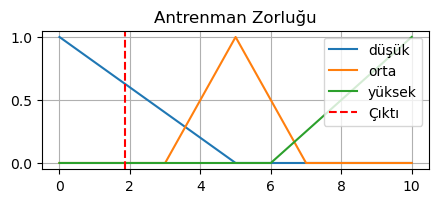

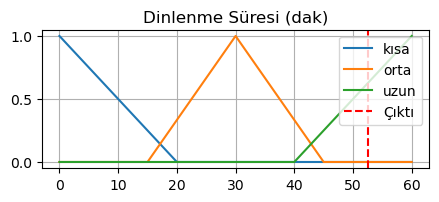

In [39]:
import tkinter as tk
from tkinter import messagebox
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import Image, ImageTk
import requests
from io import BytesIO

# ---------- BULANIK DEĞİŞKENLER VE KURALLAR ----------

kalp_atisi = ctrl.Antecedent(np.arange(40, 181, 1), 'Kalp Atış Hızı (BPM)')
kas_yorgunlugu = ctrl.Antecedent(np.arange(0, 11, 1), 'Kas Yorgunluğu (0-10)')
onceki_set = ctrl.Antecedent(np.arange(0, 11, 1), 'Önceki Set Zorluğu (0-10)')
uyku = ctrl.Antecedent(np.arange(0, 11, 1), 'Uyku Kalitesi (0-10)')
su = ctrl.Antecedent(np.arange(0, 4.1, 0.1), 'Su Tüketimi (L)')

antrenman_zorlugu = ctrl.Consequent(np.arange(0, 11, 1), 'Antrenman Zorluğu')
dinlenme_suresi = ctrl.Consequent(np.arange(0, 61, 1), 'Dinlenme Süresi (dak)')

# Üyelik fonksiyonları
kalp_atisi['düşük'] = fuzz.trimf(kalp_atisi.universe, [40, 40, 90])
kalp_atisi['orta'] = fuzz.trimf(kalp_atisi.universe, [80, 110, 140])
kalp_atisi['yüksek'] = fuzz.trimf(kalp_atisi.universe, [130, 180, 180])

kas_yorgunlugu['az'] = fuzz.trimf(kas_yorgunlugu.universe, [0, 0, 5])
kas_yorgunlugu['orta'] = fuzz.trimf(kas_yorgunlugu.universe, [3, 5, 7])
kas_yorgunlugu['çok'] = fuzz.trimf(kas_yorgunlugu.universe, [6, 10, 10])

onceki_set['kolay'] = fuzz.trimf(onceki_set.universe, [0, 0, 5])
onceki_set['orta'] = fuzz.trimf(onceki_set.universe, [3, 5, 7])
onceki_set['zor'] = fuzz.trimf(onceki_set.universe, [6, 10, 10])

uyku['kötü'] = fuzz.trimf(uyku.universe, [0, 0, 5])
uyku['orta'] = fuzz.trimf(uyku.universe, [3, 5, 7])
uyku['iyi'] = fuzz.trimf(uyku.universe, [6, 10, 10])

su['az'] = fuzz.trimf(su.universe, [0, 0, 2])
su['yeterli'] = fuzz.trimf(su.universe, [1, 2, 3])
su['çok'] = fuzz.trimf(su.universe, [2.5, 4, 4])

antrenman_zorlugu['düşük'] = fuzz.trimf(antrenman_zorlugu.universe, [0, 0, 5])
antrenman_zorlugu['orta'] = fuzz.trimf(antrenman_zorlugu.universe, [3, 5, 7])
antrenman_zorlugu['yüksek'] = fuzz.trimf(antrenman_zorlugu.universe, [6, 10, 10])

dinlenme_suresi['kısa'] = fuzz.trimf(dinlenme_suresi.universe, [0, 0, 20])
dinlenme_suresi['orta'] = fuzz.trimf(dinlenme_suresi.universe, [15, 30, 45])
dinlenme_suresi['uzun'] = fuzz.trimf(dinlenme_suresi.universe, [40, 60, 60])

# Kurallar
rule1 = ctrl.Rule(kalp_atisi['yüksek'] | kas_yorgunlugu['çok'] | onceki_set['zor'],
                  (antrenman_zorlugu['yüksek'], dinlenme_suresi['uzun']))
rule2 = ctrl.Rule(uyku['kötü'] | su['az'],
                  (antrenman_zorlugu['düşük'], dinlenme_suresi['uzun']))
rule3 = ctrl.Rule(kalp_atisi['orta'] & kas_yorgunlugu['orta'] & uyku['iyi'],
                  (antrenman_zorlugu['orta'], dinlenme_suresi['orta']))
rule4 = ctrl.Rule(kalp_atisi['düşük'] & kas_yorgunlugu['az'],
                  (antrenman_zorlugu['düşük'], dinlenme_suresi['kısa']))

training_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4])
training = ctrl.ControlSystemSimulation(training_system)

# ---------- ARAYÜZ SINIFI ----------

class KickboxingApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("🥊 Kickboks Antrenman Kontrolcüsü 🥊")
        self.geometry("650x900")
        self.configure(bg="#222831")

        url = "https://images.pexels.com/photos/10689269/pexels-photo-10689269.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
        try:
            response = requests.get(url)
            img_data = response.content
            self.bg_image = Image.open(BytesIO(img_data)).resize((650, 900))
            self.bg_photo = ImageTk.PhotoImage(self.bg_image)
            self.bg_label = tk.Label(self, image=self.bg_photo)
            self.bg_label.place(x=0, y=0, relwidth=1, relheight=1)
        except Exception as e:
            messagebox.showwarning("Uyarı", f"Arka plan resmi indirilemedi.\n{e}")

        title = tk.Label(self, text="🥋 Kickboks Antrenman Kontrolcüsü", font=("Helvetica", 20, "bold"), fg="#00adb5", bg="#222831")
        title.pack(pady=10)

        self.entries = {}
        self.inputs = [
            ("Kalp Atış Hızı (BPM)", 40, 180, kalp_atisi),
            ("Kas Yorgunluğu (0-10)", 0, 10, kas_yorgunlugu),
            ("Önceki Set Zorluğu (0-10)", 0, 10, onceki_set),
            ("Uyku Kalitesi (0-10)", 0, 10, uyku),
            ("Su Tüketimi (L)", 0, 4, su)
        ]

        for label_text, min_val, max_val, _ in self.inputs:
            frame = tk.Frame(self, bg="#393e46")
            frame.pack(pady=5, padx=15, fill='x')
            lbl = tk.Label(frame, text=label_text + " 🏋️‍♂️", font=("Helvetica", 12), fg="#eeeeee", bg="#393e46")
            lbl.pack(side="left", padx=10)
            entry = tk.Entry(frame, font=("Helvetica", 12))
            entry.pack(side="left", fill='x', expand=True, padx=10)
            self.entries[label_text] = (entry, min_val, max_val)

        calc_btn = tk.Button(self, text="🚀 Hesapla", font=("Helvetica", 14, "bold"), bg="#00adb5", fg="#222831", command=self.calculate)
        calc_btn.pack(pady=15)

        self.result_antrenman = tk.Label(self, text="", font=("Helvetica", 16, "bold"), fg="#ffd369", bg="#222831")
        self.result_antrenman.pack(pady=5)
        self.result_dinlenme = tk.Label(self, text="", font=("Helvetica", 16, "bold"), fg="#ffd369", bg="#222831")
        self.result_dinlenme.pack(pady=5)

        self.graph_frame = tk.Frame(self, bg="#222831")
        self.graph_frame.pack(pady=10, fill='both', expand=True)

        self.canvas_antrenman = None
        self.canvas_dinlenme = None
        self.current_values = {}

    def calculate(self):
        try:
            for label_text, min_val, max_val, _ in self.inputs:
                val_str = self.entries[label_text][0].get()
                val = float(val_str)
                if not (min_val <= val <= max_val):
                    raise ValueError(f"{label_text} {min_val}-{max_val} aralığında olmalı.")
                self.current_values[label_text] = val

            training.input['Kalp Atış Hızı (BPM)'] = self.current_values["Kalp Atış Hızı (BPM)"]
            training.input['Kas Yorgunluğu (0-10)'] = self.current_values["Kas Yorgunluğu (0-10)"]
            training.input['Önceki Set Zorluğu (0-10)'] = self.current_values["Önceki Set Zorluğu (0-10)"]
            training.input['Uyku Kalitesi (0-10)'] = self.current_values["Uyku Kalitesi (0-10)"]
            training.input['Su Tüketimi (L)'] = self.current_values["Su Tüketimi (L)"]

            training.compute()

            antrenman = training.output['Antrenman Zorluğu']
            dinlenme = training.output['Dinlenme Süresi (dak)']

            self.result_antrenman.config(text=f"🏋️ Antrenman Zorluğu: {antrenman:.2f}")
            self.result_dinlenme.config(text=f"🧘 Dinlenme Süresi: {dinlenme:.2f} dakika")

            self.plot_results(antrenman_zorlugu, antrenman, True)
            self.plot_results(dinlenme_suresi, dinlenme, False)

        except ValueError as ve:
            messagebox.showerror("Giriş Hatası", str(ve))
        except Exception as e:
            messagebox.showerror("Hata", f"Bir hata oluştu:\n{e}")

    def plot_results(self, variable, output_value, is_antrenman):
        fig, ax = plt.subplots(figsize=(5, 1.8), dpi=100)
        for term in variable.terms:
            ax.plot(variable.universe, variable[term].mf, label=term)
        ax.axvline(output_value, color='r', linestyle='--', label='Çıktı')
        ax.set_title(variable.label)
        ax.legend(loc='upper right')
        ax.grid(True)

        canvas = FigureCanvasTkAgg(fig, master=self.graph_frame)
        canvas.draw()
        if is_antrenman:
            if self.canvas_antrenman:
                self.canvas_antrenman.get_tk_widget().destroy()
            self.canvas_antrenman = canvas
        else:
            if self.canvas_dinlenme:
                self.canvas_dinlenme.get_tk_widget().destroy()
            self.canvas_dinlenme = canvas
        canvas.get_tk_widget().pack(pady=5)

# ---------- UYGULAMA BAŞLAT ----------

if __name__ == "__main__":
    app = KickboxingApp()
    app.mainloop()
